<a href="https://colab.research.google.com/github/OlgaChaganova/MfSC_thesis/blob/main/MFC_Recommendation_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
device_name = tf.test.gpu_device_name()
device_name

'/device:GPU:0'

# Подключение библиотек


In [ ]:
!pip install cpt

In [ ]:
pip install catboost

In [ ]:
pip install keras-tqdm

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf

import catboost
from cpt.cpt import Cpt

import json

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, accuracy_score #Метрика качества 
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder, MinMaxScaler 

#Настройка гиперпараметров с помощью байессовской оптимизацией
from hyperopt import hp, tpe
from hyperopt.fmin import fmin

import math 
import matplotlib.pyplot as plt 

from keras.models import Sequential 
from keras.layers import Dense, LSTM, Dropout
from keras.utils import np_utils
from keras.callbacks import History #история обучения
from keras_tqdm import TQDMNotebookCallback

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **1 Загрузка данных**
Деление заявителей на train и test

In [ ]:
raw_data = pd.read_csv('drive/My Drive/ВКР/1 ДАННЫЕ/train.csv',
                    usecols = [1,4], nrows=2713723, names=['ID', 'service_title'], dtype=np.int32)

In [ ]:
requester = pd.read_csv('drive/My Drive/ВКР/1 ДАННЫЕ/requester.csv', sep=';', usecols = [0,1])
requester.columns = ['type', 'ID']

In [ ]:
data_with_types = raw_data.merge(requester, on='ID')

#разбивка данных по каждому виду заявителей
data1 = data_with_types[data_with_types['type'] == 1].copy()
data2 = data_with_types[data_with_types['type'] == 2].copy()
data3 = data_with_types[data_with_types['type'] == 3].copy()

del data_with_types

In [ ]:
# функция для деления выборки заявителей на тренировочную и тестовую
def split_requesters(data_about_requesters, test_size = 0.2): 
  unique_ids = list(set(data_about_requesters['ID'])) #множество уникальных значений ID
  indexes = list(range(0,len(unique_ids)))
  indexes = shuffle(indexes, random_state=8)

  test_indexes = unique_ids[:int(len(unique_ids)*test_size)]
  test_requesters = data_about_requesters[data_about_requesters['ID'].isin(test_indexes)]

  train_indexes = unique_ids[int(len(unique_ids)*test_size):]
  train_requesters = data_about_requesters[data_about_requesters['ID'].isin(train_indexes)]

  return train_requesters, test_requesters

In [ ]:
#Train и test выборки по типам заявителей
train_req1, test_req1 = split_requesters(data1, 0.17)
train_req2, test_req2 = split_requesters(data2, 0.245)
train_req3, test_req3 = split_requesters(data3, 0.1832)

In [ ]:
TRAIN = pd.concat([train_req1, train_req2, train_req3])
TEST = pd.concat([test_req1, test_req2, test_req3])

In [ ]:
del train_req1['type'], test_req1['type'], train_req2['type'], test_req2['type'], train_req3['type'], test_req3['type']

In [ ]:
del data1, data2, data3

In [ ]:
test_req1.shape[0]/train_req1.shape[0], test_req2.shape[0]/train_req2.shape[0], test_req3.shape[0]/train_req3.shape[0]
# Отношения не равны test_size, потому что test_size задает пропорции между ЗАЯВИТЕЛЯМИ, а не их ИСТОРИЕЙ ОБРАЩЕНИЙ

(0.20297245956682206, 0.20919068727991824, 0.18527422150164924)

In [ ]:
del raw_data

# **+ 2 Compact Prediction Tree**

https://cpt.readthedocs.io/en/latest/tuning.html

## Функции для подготовки данных и нахождения оптимальных параметров

In [ ]:
# Преобразование данных к нужному формату для CPT
def prepare_data_for_cpt(DATA, min_n, max_n, type): #ОТБОР ПОСЛЕДНИХ MAX_N ЗАЯВЛЕНИЙ

  data_cpt = DATA.copy()
  data_cpt['N'] = data_cpt.groupby("ID")['ID'].transform('count') #Количество заявлений от каждого пользователя
  data_cpt.sort_values(by='ID', inplace=True) #сгруппировали по ID

  data_cpt = data_cpt[data_cpt['N'] >= min_n] #удалили заемщиков с числом заявлений меньше min_n

  data_cpt = data_cpt.groupby(['ID']).aggregate(lambda x: list(x))
  data_cpt['N'] = data_cpt['N'].str[0]

#для клиентов, у которых больше max_n заявлений, оставляем max_n последних заявлений
  data_with_N_more_than_nmax = data_cpt[data_cpt['N'] >= max_n].copy()
  data_with_N_more_than_nmax['service_title'] = data_with_N_more_than_nmax['service_title'].str[-max_n:] 
  data_with_N_more_than_nmax['N'] = max_n

  data_cpt = data_cpt[data_cpt['N'] <= max_n] #оставляем заемщиков с числом заявлений не больше, чем max_n

  # Вертикальная конкатенация
  data_cpt = pd.concat([data_cpt, data_with_N_more_than_nmax], axis=0)

  data_cpt.reset_index(inplace=True)
  data_cpt.drop(columns=['ID', 'N'], inplace=True)
  data_cpt.columns = ['Service Sequence by ID']

  if type == 'train':
    return(data_cpt['Service Sequence by ID'])
  elif type == 'test':
    return data_cpt['Service Sequence by ID'].str[0:-1], data_cpt['Service Sequence by ID'].str[-1]    

In [ ]:
def FindOptimalParametres(train, X_test, y_test, tuned_params):
  max_score = 0
  y_true = y_test

  for mbr in tuned_params['MBR']:
    for length in tuned_params['split_length']:
      model = Cpt(MBR = mbr, split_length = length)
      model.fit(train)
     
      y_pred = model.predict(list(X_test)) #прогнозные значения следующей услуги для заявителей из тестовой выборки
      score = accuracy_score(y_true, y_pred)

      if score > max_score:
        max_score = score
        optimal_model = model
        optimal_length = length
        optimal_MBR = mbr
  print("Optimal parametres:\nsplit_length = ", optimal_length, "\nMBR = ", optimal_MBR, "\nAccuracy = ", max_score)


## 2.1 Для всех заявителей вместе

In [ ]:
#ДАННЫЕ

min_n = 3 #минимальное число заявлений, которое должен подать заявитель
max_n = 8 #максимально число заявлений, которое может подать заявитель

TRAIN_CPT, TEST_CPT = TRAIN.copy(), TEST.copy()
del TRAIN_CPT['type'], TEST_CPT['type']

train_cpt = prepare_data_for_cpt(TRAIN_CPT, min_n, max_n, 'train')
X_test_cpt, y_test_cpt = prepare_data_for_cpt(TEST_CPT, min_n, max_n, 'test')

# Освобождение памяти
del TRAIN_CPT, TEST_CPT

In [ ]:
#БАЗОВАЯ МОДЕЛЬ

model_cpt = Cpt() 

model_cpt.fit(train_cpt) #обучение на тренировочных последовательностях

#Метрика качества - Accuracy
y_pred = model_cpt.predict(list(X_test_cpt)) #прогнозные значения следующей услуги для заявителей из тестовой выборки
y_true = y_test_cpt

accuracy_score(y_true, y_pred)

In [ ]:
#ТЮНИНГ БАЗОВОЙ МОДЕЛИ

tuned_params = {'MBR': [0], 'split_length': range(0,10,1)} #MBR и noise_ratio ни на что не влияют
FindOptimalParametres(train_cpt, X_test_cpt, y_test_cpt, tuned_params) #Accuracy =  0.13290176736539253

## 2.2 Отдельно по типам заявителям

### 2.2.1 Физ. лица (1)

In [ ]:
# ДАННЫЕ
min_n = 3 #минимальное число заявлений, которое должен подать заявитель
max_n = 10 #максимальное число заявлений, которое может подать заявитель

train_cpt1 = prepare_data_for_cpt(train_req1, min_n, max_n, 'train')
X_test_cpt1, y_test_cpt1 = prepare_data_for_cpt(test_req1, min_n, max_n, 'test')

In [ ]:
# МОДЕЛЬ
model_cpt1 = Cpt() # базовая модель 
model_cpt1.fit(train_cpt1) #обучение на тренировочных последовательностях

#Метрика качества - Accuracy
y_pred = model_cpt1.predict(list(X_test_cpt1)) #прогнозные значения следующей услуги для заявителей из тестовой выборки
y_true = y_test_cpt1

accuracy_score(y_true, y_pred) #0.107159

In [ ]:
# ТЮНИНГ БАЗОВОЙ МОДЕЛИ 
tuned_params1 = {'MBR': [0], 'split_length': range(0,10,1)} #MBR и noise_ratio ни на что не влияют
FindOptimalParametres(train_cpt1, X_test_cpt1, y_test_cpt1, tuned_params1) # Accuracy = 0.174

### 2.2.2 Юр. лица (2)

In [ ]:
# ДАННЫЕ
min_n = 4 #минимальное число заявлений, которое должен подать заявитель
max_n = 10 #максимально число заявлений, которое может подать заявитель

train_cpt2 = prepare_data_for_cpt(train_req2, min_n, max_n, 'train')
X_test_cpt2, y_test_cpt2 = prepare_data_for_cpt(test_req2, min_n, max_n, 'test')

In [ ]:
# МОДЕЛЬ
model_cpt2 = Cpt() # базовая модель 
model_cpt2.fit(train_cpt2) #обучение на тренировочных последовательностях

#Метрика качества - Accuracy
y_pred = model_cpt2.predict(list(X_test_cpt2)) #прогнозные значения следующей услуги для заявителей из тестовой выборки
y_true = y_test_cpt2

accuracy_score(y_true, y_pred)

In [ ]:
# ТЮНИНГ БАЗОВОЙ МОДЕЛИ
tuned_params2 = {'MBR': [0], 'split_length': range(0,10,1)} #MBR и noise_ratio ни на что не влияют
FindOptimalParametres(train_cpt2, X_test_cpt2, y_test_cpt2, tuned_params2) # Accuracy = 0.39

### 2.2.3 ИП (3)

In [ ]:
# ДАННЫЕ
min_n = 3 #минимальное число заявлений, которое должен подать заявитель
max_n = 7 #максимально число заявлений, которое может подать заявитель

train_cpt3 = prepare_data_for_cpt(train_req3, min_n, max_n, 'train')
X_test_cpt3, y_test_cpt3 = prepare_data_for_cpt(test_req3, min_n, max_n, 'test')

In [ ]:
# МОДЕЛЬ
model_cpt3 = Cpt() # базовая модель 
model_cpt3.fit(train_cpt3) #обучение на тренировочных последовательностях

#Метрика качества - Accuracy
y_pred = model_cpt3.predict(list(X_test_cpt3)) #прогнозные значения следующей услуги для заявителей из тестовой выборки
y_true = y_test_cpt3

accuracy_score(y_true, y_pred) # 0.209

In [ ]:
# ТЮНИНГ БАЗОВОЙ МОДЕЛИ
tuned_params3 = {'MBR': [0], 'split_length': range(0,10,1)} #MBR и noise_ratio ни на что не влияют
FindOptimalParametres(train_cpt3, X_test_cpt3, y_test_cpt3, tuned_params3) # 0.209

### TOTAL SCORE
0.1664357391778981

In [ ]:
(0.1623602751504729*len(y_test_cpt1) + 0.3940677966101695*len(y_test_cpt2) + 0.23645320197044334*len(y_test_cpt3))/(len(y_test_cpt1) + len(y_test_cpt2) + len(y_test_cpt3))

In [ ]:
len(y_test_cpt1), len(y_test_cpt2), len(y_test_cpt3)

# **+ 3 RNN LSTM**

*Модели со скользящим окном*

METRICS:  https://keras.io/api/metrics/accuracy_metrics/#categoricalaccuracy-class

https://towardsdatascience.com/keras-accuracy-metrics-8572eb479ec7

## Функции для подготовки данных и оценки точности

In [ ]:
def prepare_test_data_for_rnn_lstm(DATA, min_n): # С ОТБОРОМ ПОСЛЕДНИХ MIN_N ЗАЯВЛЕНИЙ - для тестовых выборок
  data_rnn = DATA.copy()
  data_rnn['service_title'] = data_rnn['service_title'].astype('str') #переводим в строковый формат

  data_rnn['N'] = data_rnn.groupby("ID")['ID'].transform('count') #Количество заявлений от каждого пользователя
  data_rnn.sort_values(by='ID', inplace=True) #сгруппировали по ID

  data_rnn = data_rnn[data_rnn['N'] >= min_n] #оставляем заемщиков с числом заявлений не меньше, чем min_n

  data_rnn = data_rnn.groupby(['ID']).aggregate(lambda x: list(x))

  data_rnn['N'] = data_rnn['N'].str[0]

  #для клиентов, у которых больше min_n заявлений, оставляем min_n последних заявлений
  data_with_N_more_than_minn = data_rnn[data_rnn['N'] > min_n].copy()
  data_with_N_more_than_minn['service_title'] = data_with_N_more_than_minn['service_title'].str[-min_n:] 
  data_with_N_more_than_minn['N'] = min_n

  data_rnn = data_rnn[data_rnn['N'] <= min_n] #оставляем заемщиков с числом заявлений не больше, чем min_n

  # Вертикальная конкатенация
  data_rnn = pd.concat([data_rnn, data_with_N_more_than_minn], axis=0)

  data_rnn.reset_index(inplace=True)
  data_rnn.drop(columns=['ID', 'N'], inplace=True)
  data_rnn.columns = ['Service Sequence by ID']

  data_rnn['START_SERVICES'] = data_rnn['Service Sequence by ID'].str[0:-1]
  data_rnn['END_SERVICE'] = data_rnn['Service Sequence by ID'].str[-1]
  data_rnn.drop(columns=['Service Sequence by ID'], inplace=True)

  X_rnn = data_rnn['START_SERVICES']
  y_rnn = data_rnn['END_SERVICE']

  X_rnn = np.vstack(X_rnn.to_numpy()).reshape(X_rnn.shape[0],min_n - 1,1) 
  y_rnn = np.array(y_rnn).reshape(y_rnn.shape[0],1)

  #Переводим в категориальный формат для многоклассовой классификации -- ONE-HOT ENCONDING
  X_rnn = np_utils.to_categorical(X_rnn, num_classes=1310)[:,:,1:]
  y_rnn = np_utils.to_categorical(y_rnn, num_classes=1310)[:,1:]

  return X_rnn, y_rnn


In [ ]:
def extend_train_data_for_rnn_lstm(DATA, min_n, max_last_n): # Со скользящим окном - для тренировочных выборок
  data_rnn = DATA.copy()
  data_rnn['service_title'] = data_rnn['service_title'].astype('str') #переводим в строковый формат

  data_rnn['N'] = data_rnn.groupby("ID")['ID'].transform('count') #Количество заявлений от каждого пользователя
  data_rnn.sort_values(by='ID', inplace=True) #сгруппировали по ID

  data_rnn = data_rnn[data_rnn['N'] >= min_n] #оставляем заемщиков с числом заявлений не меньше, чем min_n

  data_rnn = data_rnn.groupby(['ID']).aggregate(lambda x: list(x))

  data_rnn['N'] = data_rnn['N'].str[0]

  data_with_N_equal_minn = data_rnn[data_rnn['N'] == min_n].copy() #доп.обработка не нужна

  #для клиентов, у которых больше min_n заявлений, оставляем max_last_n последних заявлений
  data_with_N_more_than_minn = data_rnn[data_rnn['N'] > min_n].copy()
  data_with_N_more_than_minn['service_title'] = data_with_N_more_than_minn['service_title'].str[-max_last_n:] 

  data_with_N_equal_minn.reset_index(inplace=True)
  data_with_N_equal_minn.drop('ID', axis=1, inplace=True)

  new_llist = list() # лист, в котором будут храниться новые последовательности
  data_list = list(data_with_N_more_than_minn['service_title']) # данные о заявления в формате list

  for i in range(len(data_with_N_more_than_minn)):
    lllist = data_list[i]
    for j in range(len(lllist) - min_n + 1):
      new_llist.append(lllist[j:j+min_n])
  
  extended_data = pd.DataFrame({'service_title' : new_llist, 'N' : min_n})

  data_rnn = pd.concat([data_with_N_equal_minn, extended_data], axis=0)

  data_rnn.drop(columns=['N'], inplace=True)

  data_rnn['START_SERVICES'] = data_rnn['service_title'].str[0:-1]
  data_rnn['END_SERVICE'] = data_rnn['service_title'].str[-1]
  data_rnn.drop(columns=['service_title'], inplace=True)

  X_rnn = data_rnn['START_SERVICES']
  y_rnn = data_rnn['END_SERVICE']

  X_rnn = np.vstack(X_rnn.to_numpy()).reshape(X_rnn.shape[0],min_n - 1,1) 
  y_rnn = np.array(y_rnn).reshape(y_rnn.shape[0],1)

  #Переводим в категориальный формат для многоклассовой классификации -- ONE-HOT ENCONDING
  X_rnn = np_utils.to_categorical(X_rnn, num_classes=1310)[:,:,1:] #удаляем первый столбец, соответствующий услуге "0"
  y_rnn = np_utils.to_categorical(y_rnn, num_classes=1310)[:,1:]

  return X_rnn, y_rnn

In [ ]:
def accuracy_score_rnn(y_true, y_pred):
  print("Accuracy is ", round(sum(y_true[np.arange(len(y_pred)), np.argmax(y_pred, axis=1)])/y_pred.shape[0], 5)) 

In [ ]:
def build_graphs(history, num_epochs, K):
  train_loss = history.history['loss']
  val_loss = history.history['val_loss']

  train_acc = history.history['categorical_accuracy']
  val_acc= history.history['val_categorical_accuracy']

  train_top_k_acc = history.history['top_k_categorical_accuracy']
  val_top_k_acc = history.history['val_top_k_categorical_accuracy']

  xc = range(1, num_epochs+1, 1)

  fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

  plt.subplots_adjust(left=0.1, right=3, wspace=0.3, hspace=0.3, bottom=0.1, top=1)

  ax1.set_title('Loss on train and validation subsamples')
  ax1.set_xlabel('epoch')
  ax1.set_ylabel('loss')
  ax1.plot(xc, train_loss, label="train")
  ax1.plot(xc, val_loss, label="val")
  ax1.set_xticks(np.arange(min(xc), max(xc)+1, 1))
  ax1.legend()

  ax2.set_title('Categorical accuracy on train and validation subsamples')
  ax2.set_xlabel('epoch')
  ax2.set_ylabel('Accuracy')
  ax2.plot(xc, train_acc, label="train")
  ax2.plot(xc, val_acc, label="val")
  ax2.set_xticks(np.arange(min(xc), max(xc)+1, 1))
  ax2.legend()

  ax3.set_title('Top ' + str(K) + ' Categorical accuracy on train and validation subsamples')
  ax3.set_xlabel('epoch')
  ax3.set_ylabel('Top ' + str(K) + ' Accuracy')
  ax3.plot(xc, train_top_k_acc, label="train")
  ax3.plot(xc, val_top_k_acc, label="val")
  ax3.set_xticks(np.arange(min(xc), max(xc)+1, 1))
  ax3.legend()

  None

## 3.1 Для **всех** заявителей

In [ ]:
#ДАННЫЕ

min_n = 5 #минимальное число заявлений, которое должен подать заявитель, чтобы попасть в тренировочную выборку

TRAIN_RNN, TEST_RNN = TRAIN.copy(), TEST.copy()
del TRAIN_RNN['type'], TEST_RNN['type']

X_train_rnn, y_train_rnn = extend_train_data_for_rnn_lstm(TRAIN_RNN, min_n, 10)
X_test_rnn, y_test_rnn = prepare_test_data_for_rnn_lstm(TEST_RNN, min_n)

del TRAIN_RNN, TEST_RNN

In [ ]:
#МОДЕЛЬ

model_rnn = Sequential() #Accuracy is  0.3524, epochs = 5,  min_n = 5 увеличение числа нейронов в слоях не привело к улучшению результата
model_rnn.add(LSTM(256, input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2]), return_sequences=True, activation='relu'))
model_rnn.add(Dropout(0.2))
model_rnn.add(LSTM(128, activation='relu'))
model_rnn.add(Dropout(0.1))
model_rnn.add(Dense(y_train_rnn.shape[1], activation='softmax'))
model_rnn.compile(loss='categorical_crossentropy', optimizer='adam')

model_rnn.fit(X_train_rnn, y_train_rnn, epochs=5,  validation_split=0.2, verbose=1)

In [ ]:
#ТОЧНОСТЬ

y_pred = model_rnn.predict(X_test_rnn, verbose=0)
print("Accuracy is ", round(sum(y_test_rnn[np.arange(len(y_pred)), np.argmax(y_pred, axis=1)])/y_test_rnn.shape[0], 5)) #Accuracy is  0.3443 256 - 128 

Accuracy is  0.3528


## 3.2 Для **отдельных** групп заявителей

### Физ. лица (1)
*6, 8, 6, epochs = 10, Acc 0.35279*

In [ ]:
# ДАННЫЕ

min_n = 6 #минимальное число заявлений, которое должен подать заявитель, чтобы попасть в тренировочную выборку
max_last_n = 8 #Максимальное число заявлений, которое должен подать заявитель. Если их больше, отбираются последние max_last_n заявлений

X_train_rnn1, y_train_rnn1 = extend_train_data_for_rnn_lstm(train_req1, min_n, max_last_n)
X_test_rnn1, y_test_rnn1 = prepare_test_data_for_rnn_lstm(test_req1, min_n)

In [ ]:
X_train_rnn1.shape, y_train_rnn1.shape, X_test_rnn1.shape, y_test_rnn1.shape

((148781, 5, 1309), (148781, 1309), (13894, 5, 1309), (13894, 1309))

In [ ]:
# МОДЕЛЬ
num_epochs1 = 8
K1 = 5 #top number

model_rnn1 = Sequential() #Accuracy is  0.3524, epochs = 5,  min_n = 5 увеличение числа нейронов в слоях не привело к улучшению результата
model_rnn1.add(LSTM(512, input_shape=(X_train_rnn1.shape[1], X_train_rnn1.shape[2]), return_sequences=True, activation='relu'))
model_rnn1.add(Dropout(0.2))
model_rnn1.add(LSTM(256, activation='relu'))
model_rnn1.add(Dropout(0.1))
model_rnn1.add(Dense(y_train_rnn1.shape[1], activation='softmax'))

model_rnn1.compile(loss='categorical_crossentropy',
                   optimizer='adam',
                   metrics=[tf.keras.metrics.CategoricalAccuracy(),
                            tf.keras.metrics.TopKCategoricalAccuracy(k=K1)])

history1 = model_rnn1.fit(X_train_rnn1, y_train_rnn1,
                          epochs=num_epochs1,
                          validation_split=0.2,
                          batch_size=64,
                          verbose=1)

Epoch 1/8
1860/1860 [==============================] - 49s 24ms/step - loss: 3.5268 - categorical_accuracy: 0.2748 - top_k_categorical_accuracy: 0.5339 - val_loss: 2.9750 - val_categorical_accuracy: 0.3136 - val_top_k_categorical_accuracy: 0.5971
Epoch 2/8
1860/1860 [==============================] - 43s 23ms/step - loss: 2.8461 - categorical_accuracy: 0.3362 - top_k_categorical_accuracy: 0.6392 - val_loss: 2.8763 - val_categorical_accuracy: 0.3212 - val_top_k_categorical_accuracy: 0.6157
Epoch 3/8
1860/1860 [==============================] - 43s 23ms/step - loss: 2.7428 - categorical_accuracy: 0.3429 - top_k_categorical_accuracy: 0.6592 - val_loss: 2.8541 - val_categorical_accuracy: 0.3229 - val_top_k_categorical_accuracy: 0.6264
Epoch 4/8
1860/1860 [==============================] - 42s 23ms/step - loss: 2.6743 - categorical_accuracy: 0.3495 - top_k_categorical_accuracy: 0.6720 - val_loss: 2.8121 - val_categorical_accuracy: 0.3277 - val_top_k_categorical_accuracy: 0.6402
Epoch 5/8
18

In [ ]:
y_pred_rnn1 = model_rnn1.predict(X_test_rnn1, verbose=0)
accuracy_score_rnn(y_test_rnn1, y_pred_rnn1)

Accuracy is  0.35152


In [ ]:
del X_train_rnn1, y_train_rnn1, X_test_rnn1, y_test_rnn1

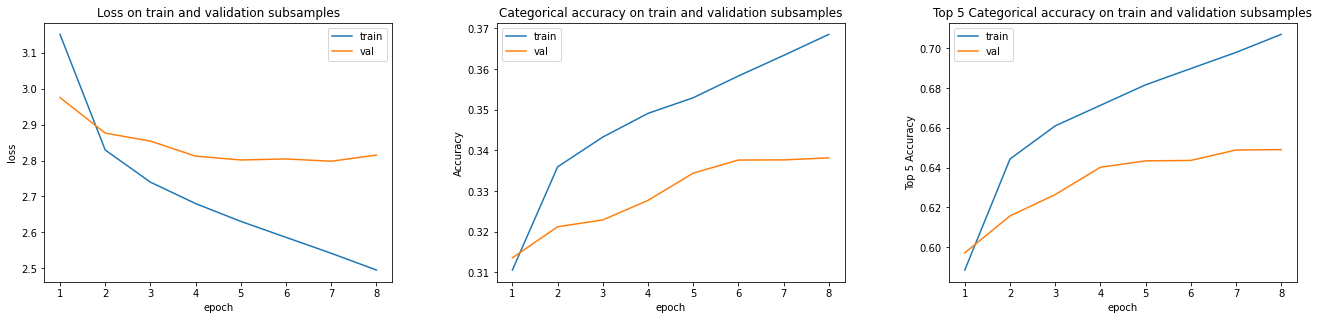

In [ ]:
 build_graphs(history1, num_epochs1, K1)

In [ ]:
m = tf.keras.metrics.TopKCategoricalAccuracy(k=5)
m.update_state(y_test_rnn1, y_pred_rnn1)
m.result().numpy()

0.6753995

In [ ]:
 build_graphs(history1, num_epochs1, K1)

In [ ]:
 build_graphs(history1, num_epochs1, K1)

### Юр. лица (2)  
*6, 30, 6, epochs=10, Acc 0.70825*

*! 7, 1000, 7, epochs=5, Acc 0.72059 (512 - 256 neurons)*

In [ ]:
# ДАННЫЕ

min_n = 7 #минимальное число заявлений, которое должен подать заявитель, чтобы попасть в тренировочную выборку
max_last_n = 10000 #Максимальное число заявлений, которое должен подать заявитель. Если их больше, отбираются последние max_last_n заявлений

X_train_rnn2, y_train_rnn2 = extend_train_data_for_rnn_lstm(train_req2, min_n, max_last_n)
X_test_rnn2, y_test_rnn2 = prepare_test_data_for_rnn_lstm(test_req2, min_n)

#6, 30, 6, epochs=10, Acc 0.71036

In [ ]:
X_train_rnn2.shape, y_train_rnn2.shape, X_test_rnn2.shape, y_test_rnn2.shape

((116197, 6, 1309), (116197, 1309), (408, 6, 1309), (408, 1309))

In [ ]:
del X_train_rnn2, y_train_rnn2, X_test_rnn2, y_test_rnn2

In [ ]:
# МОДЕЛЬ
num_epochs2 = 7
K = 5 #top number

model_rnn2 = Sequential() #
model_rnn2.add(LSTM(512, input_shape=(X_train_rnn2.shape[1], X_train_rnn2.shape[2]), return_sequences=True, activation='relu'))
model_rnn2.add(Dropout(0.2))
model_rnn2.add(LSTM(256, activation='relu'))
model_rnn2.add(Dropout(0.1))
model_rnn2.add(Dense(y_train_rnn2.shape[1], activation='softmax'))

model_rnn2.compile(loss='categorical_crossentropy',
                   optimizer='adam',
                   metrics=[tf.keras.metrics.CategoricalAccuracy(),
                            tf.keras.metrics.TopKCategoricalAccuracy(k=K)])

history2 = model_rnn2.fit(X_train_rnn2, y_train_rnn2, 
                          epochs=num_epochs2, 
                          validation_split=0.2, 
                          shuffle=True, 
                          verbose=1)

Epoch 1/7
2905/2905 [==============================] - 87s 28ms/step - loss: 0.7092 - categorical_accuracy: 0.8723 - top_k_categorical_accuracy: 0.9781 - val_loss: 0.6921 - val_categorical_accuracy: 0.8822 - val_top_k_categorical_accuracy: 0.9553
Epoch 2/7
2905/2905 [==============================] - 79s 27ms/step - loss: 0.3901 - categorical_accuracy: 0.9019 - top_k_categorical_accuracy: 0.9866 - val_loss: 0.6672 - val_categorical_accuracy: 0.8820 - val_top_k_categorical_accuracy: 0.9602
Epoch 3/7
2905/2905 [==============================] - 78s 27ms/step - loss: 0.3706 - categorical_accuracy: 0.9036 - top_k_categorical_accuracy: 0.9887 - val_loss: 0.6604 - val_categorical_accuracy: 0.8859 - val_top_k_categorical_accuracy: 0.9608
Epoch 4/7
2905/2905 [==============================] - 78s 27ms/step - loss: 0.3623 - categorical_accuracy: 0.9047 - top_k_categorical_accuracy: 0.9895 - val_loss: 0.6390 - val_categorical_accuracy: 0.8854 - val_top_k_categorical_accuracy: 0.9605
Epoch 5/7
29

In [ ]:
# ТОЧНОСТЬ

y_pred_rnn2 = model_rnn2.predict(X_test_rnn2, verbose=0)
accuracy_score_rnn(y_test_rnn2, y_pred_rnn2)

Accuracy is  0.70343


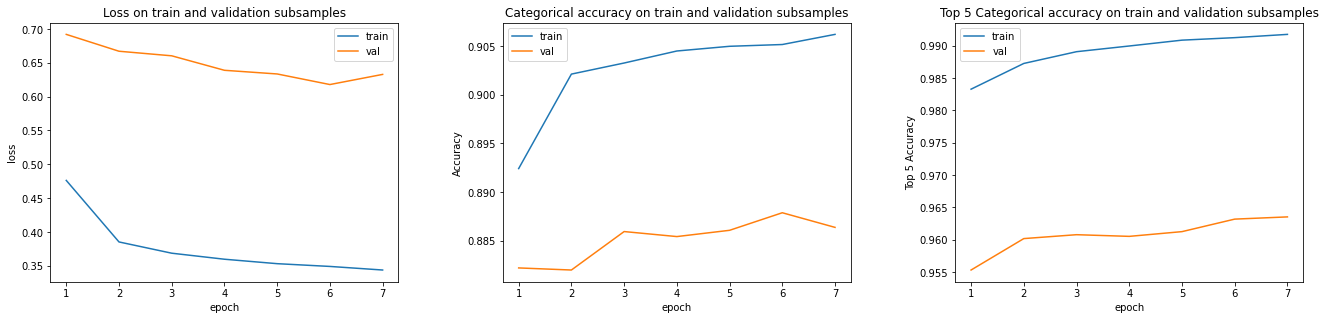

In [ ]:
 build_graphs(history2, num_epochs2, 5)

In [ ]:
m = tf.keras.metrics.TopKCategoricalAccuracy(k=5)
m.update_state(y_test_rnn2, y_pred_rnn2)
m.result().numpy()

0.90931374

### ИП (3)
*4, 100, 4, epochs = 20, Acc  0.3547*

In [ ]:
# ДАННЫЕ

min_n = 4 #минимальное число заявлений, которое должен подать заявитель, чтобы попасть в тренировочную выборку
max_last_n = 10000 #Максимальное число заявлений, которое должен подать заявитель. Если их больше, отбираются последние max_last_n заявлений

X_train_rnn3, y_train_rnn3 = extend_train_data_for_rnn_lstm(train_req3, min_n, max_last_n)
X_test_rnn3, y_test_rnn3 = prepare_test_data_for_rnn_lstm(test_req3, min_n)

# 3, 30, epochs = 20, Acc 0.32474
# 4, 100, epochs = 20, Acc  0.35043
# 8, 80, epochs = 20, Acc 0.39474

In [ ]:
X_train_rnn3.shape, y_train_rnn3.shape, X_test_rnn3.shape, y_test_rnn3.shape

((6647, 3, 1309), (6647, 1309), (234, 3, 1309), (234, 1309))

In [ ]:
# МОДЕЛЬ
num_epochs3 = 20
K = 5 #top number

model_rnn3 = Sequential() 
model_rnn3.add(LSTM(256, input_shape=(X_train_rnn3.shape[1], X_train_rnn3.shape[2]), return_sequences=True, activation='relu'))
model_rnn3.add(Dropout(0.1))
model_rnn3.add(LSTM(128, activation='relu'))
model_rnn3.add(Dropout(0.1))
model_rnn3.add(Dense(y_train_rnn3.shape[1], activation='softmax'))

model_rnn3.compile(loss='categorical_crossentropy',
                   optimizer='adam',
                   metrics=[tf.keras.metrics.CategoricalAccuracy(),
                            tf.keras.metrics.TopKCategoricalAccuracy(k=K)])

history3 = model_rnn3.fit(X_train_rnn3, y_train_rnn3,
                          epochs=num_epochs3,
                          validation_split=0.2,
                          shuffle=True, 
                          verbose=1)

Epoch 1/20
167/167 [==============================] - 5s 17ms/step - loss: 5.5072 - categorical_accuracy: 0.1686 - top_k_categorical_accuracy: 0.4534 - val_loss: 3.3885 - val_categorical_accuracy: 0.0850 - val_top_k_categorical_accuracy: 0.3278
Epoch 2/20
167/167 [==============================] - 3s 15ms/step - loss: 3.4554 - categorical_accuracy: 0.2854 - top_k_categorical_accuracy: 0.5384 - val_loss: 2.4985 - val_categorical_accuracy: 0.3301 - val_top_k_categorical_accuracy: 0.6421
Epoch 3/20
167/167 [==============================] - 3s 15ms/step - loss: 2.9923 - categorical_accuracy: 0.3532 - top_k_categorical_accuracy: 0.6377 - val_loss: 2.4131 - val_categorical_accuracy: 0.3421 - val_top_k_categorical_accuracy: 0.6526
Epoch 4/20
167/167 [==============================] - 3s 15ms/step - loss: 2.9175 - categorical_accuracy: 0.3624 - top_k_categorical_accuracy: 0.6478 - val_loss: 2.3938 - val_categorical_accuracy: 0.3436 - val_top_k_categorical_accuracy: 0.6714
Epoch 5/20
167/167 [

In [ ]:
history3.history.keys() # metrics that were calculated on each epoch

dict_keys(['loss', 'categorical_accuracy', 'top_k_categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'val_top_k_categorical_accuracy'])

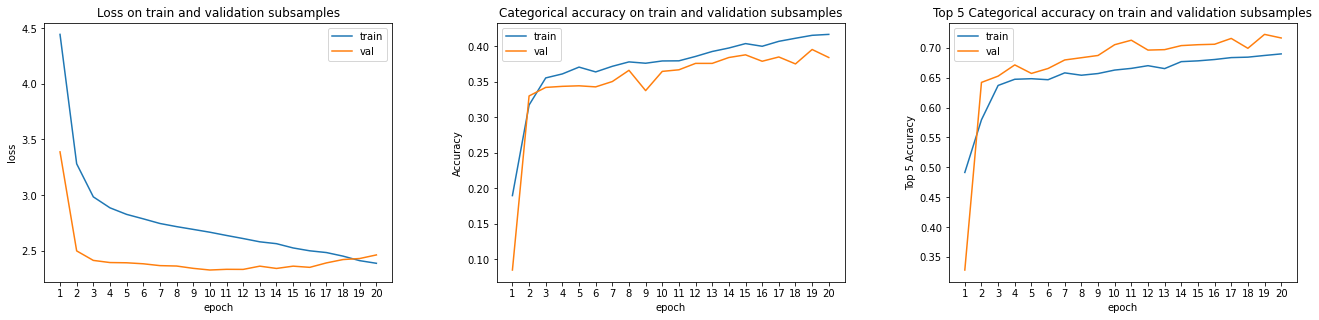

In [ ]:
 build_graphs(history3, num_epochs3, 5)

In [ ]:
# ТОЧНОСТЬ на ТЕСТЕ (!)

y_pred_rnn3 = model_rnn3.predict(X_test_rnn3, verbose=0)
accuracy_score_rnn(y_test_rnn3, y_pred_rnn3)

Accuracy is  0.30342


In [ ]:
m = tf.keras.metrics.TopKCategoricalAccuracy(k=5)
m.update_state(y_test_rnn3, y_pred_rnn3)
m.result().numpy()

0.6752137

### **TOTAL SCORE**
0.362968

In [ ]:
(0.35279*len(y_test_rnn1) + 0.70825*len(y_test_rnn2) + 0.3547*len(y_test_rnn3))/(len(y_test_rnn1) + len(y_test_rnn2) + len(y_test_rnn3))

0.36433496096425144

In [ ]:
len(y_test_rnn1), len(y_test_rnn2), len(y_test_rnn3)

(13895, 473, 234)

# **+ 3 CatBoost Classification**

### Функция для подготовки данных

In [ ]:
def extend_train_data_for_catboost(DATA, min_n, max_last_n): # Со скользящим окном - для тренировочных выборок
  data_xgb = DATA.copy()
  data_xgb['service_title'] = data_xgb['service_title'].astype('str') #переводим в строковый формат

  data_xgb['N'] = data_xgb.groupby("ID")['ID'].transform('count') #Количество заявлений от каждого пользователя
  data_xgb.sort_values(by='ID', inplace=True) #сгруппировали по ID

  data_xgb = data_xgb[data_xgb['N'] >= min_n] #оставляем заемщиков с числом заявлений не меньше, чем min_n

  data_xgb = data_xgb.groupby(['ID']).aggregate(lambda x: list(x))

  data_xgb['N'] = data_xgb['N'].str[0]

  data_with_N_equal_minn = data_xgb[data_xgb['N'] == min_n].copy() #доп.обработка не нужна

  #для клиентов, у которых больше min_n заявлений, оставляем max_last_n последних заявлений
  data_with_N_more_than_minn = data_xgb[data_xgb['N'] > min_n].copy()
  data_with_N_more_than_minn['service_title'] = data_with_N_more_than_minn['service_title'].str[-max_last_n:] 

  data_with_N_equal_minn.reset_index(inplace=True)
  data_with_N_equal_minn.drop('ID', axis=1, inplace=True)

  new_llist = list() # лист, в котором будут храниться новые последовательности
  data_list = list(data_with_N_more_than_minn['service_title']) # данные о заявления в формате list

  for i in range(len(data_with_N_more_than_minn)):
    lllist = data_list[i]
    for j in range(len(lllist) - min_n + 1):
      new_llist.append(lllist[j:j+min_n])
  
  extended_data = pd.DataFrame({'service_title' : new_llist, 'N' : min_n})

  data_xgb = pd.concat([data_with_N_equal_minn, extended_data], axis=0)

  data_xgb.drop(columns=['N'], inplace=True)

  data_xgb['START_SERVICES'] = data_xgb['service_title'].str[0:-1]
  data_xgb['END_SERVICE'] = data_xgb['service_title'].str[-1]
  data_xgb.drop(columns=['service_title'], inplace=True)

  X_xgb = data_xgb[['START_SERVICES']]
  y_xgb = data_xgb[['END_SERVICE']]

  col_names = list()
  for i in range(min_n-1):
    col_names.append('ser' + str(i))

  X_xgb[col_names] = X_xgb.START_SERVICES.to_list()
  X_xgb = X_xgb.drop(columns=['START_SERVICES'])

  return X_xgb, y_xgb

In [ ]:
def prepare_test_data_for_catboost(DATA, min_n): # для тестовых выборок
  data_xgb = DATA.copy()
  data_xgb['service_title'] = data_xgb['service_title'].astype('str') #переводим в строковый формат

  data_xgb['N'] = data_xgb.groupby("ID")['ID'].transform('count') #Количество заявлений от каждого пользователя
  data_xgb.sort_values(by='ID', inplace=True) #сгруппировали по ID

  data_xgb = data_xgb[data_xgb['N'] >= min_n] #оставляем заемщиков с числом заявлений не меньше, чем min_n

  data_xgb = data_xgb.groupby(['ID']).aggregate(lambda x: list(x))

  data_xgb['N'] = data_xgb['N'].str[0]

  #для клиентов, у которых больше min_n заявлений, оставляем min_n последних заявлений
  data_with_N_more_than_minn = data_xgb[data_xgb['N'] > min_n].copy()
  data_with_N_more_than_minn['service_title'] = data_with_N_more_than_minn['service_title'].str[-min_n:] 
  data_with_N_more_than_minn['N'] = min_n

  data_xgb = data_xgb[data_xgb['N'] <= min_n]

  data_xgb = pd.concat([data_xgb, data_with_N_more_than_minn], axis=0)

  data_xgb.reset_index(inplace=True)
  data_xgb.drop(columns=['ID','N'], inplace=True)

  data_xgb['START_SERVICES'] = data_xgb['service_title'].str[0:-1]
  data_xgb['END_SERVICE'] = data_xgb['service_title'].str[-1]
  data_xgb.drop(columns=['service_title'], inplace=True)

  X_xgb = data_xgb[['START_SERVICES']]
  y_xgb = data_xgb[['END_SERVICE']]

  col_names = list()
  for i in range(min_n-1):
    col_names.append('ser' + str(i))

  X_xgb[col_names] = X_xgb.START_SERVICES.to_list()
  X_xgb = X_xgb.drop(columns=['START_SERVICES'])

  return X_xgb, y_xgb

In [ ]:
def accuracy_ctb(y_true, y_pred):
  res = y_true == y_pred
  return(len(res[res['END_SERVICE'] == True]) / len(res))

In [ ]:
def return_true_predicts(X_test, y_test, y_pred):
  predicts_df = pd.DataFrame(data = X_test)
  predicts_df['pred_ser'] = y_pred
  predicts_df['is_true_pred'] =  y_test == y_pred
  return predicts_df[predicts_df['is_true_pred'] == True]

### Физ. лица (1)

In [ ]:
# ДАННЫЕ

min_n = 6
max_last_n = 7

X_train_ctb1, y_train_ctb1 = extend_train_data_for_catboost(train_req1, min_n, max_last_n)
X_test_ctb1, y_test_ctb1 = prepare_test_data_for_catboost(test_req1, min_n)

cat_features1 = list(range(0, X_train_ctb1.shape[1])) #категориальные переменные

X_train_ctb1.shape

# 5,5 iterations=15, learning_rate=0.05, depth=7 GPU | Accuracy is  0.28753115938342577 time 364

(113158, 5)

In [ ]:
#МОДЕЛЬ

model_ctb1 = catboost.CatBoostClassifier(iterations=150, learning_rate=0.05, depth=4,
                                         loss_function='MultiClass', random_state=8, task_type='GPU')

model_ctb1.fit(X_train_ctb1, y_train_ctb1, cat_features=cat_features1, verbose=10)

0:	learn: 5.1943908	total: 12.8s	remaining: 31m 44s
10:	learn: 6.3480659	total: 2m 20s	remaining: 29m 33s
20:	learn: 4.5413454	total: 4m 29s	remaining: 27m 36s
30:	learn: 4.2596883	total: 6m 39s	remaining: 25m 32s
40:	learn: 4.1675920	total: 8m 49s	remaining: 23m 26s
50:	learn: 4.1050395	total: 10m 58s	remaining: 21m 18s
60:	learn: 4.0475353	total: 13m 8s	remaining: 19m 10s
70:	learn: 4.0015374	total: 15m 18s	remaining: 17m 2s
80:	learn: 3.9619680	total: 17m 28s	remaining: 14m 53s
90:	learn: 3.9296238	total: 19m 38s	remaining: 12m 44s
100:	learn: 3.9004558	total: 21m 48s	remaining: 10m 34s
110:	learn: 3.8743761	total: 23m 58s	remaining: 8m 25s
120:	learn: 3.8537012	total: 26m 8s	remaining: 6m 15s
130:	learn: 3.8316463	total: 28m 17s	remaining: 4m 6s
140:	learn: 3.8115831	total: 30m 27s	remaining: 1m 56s
149:	learn: 3.7948941	total: 32m 24s	remaining: 0us


In [ ]:
y_pred_ctb1 = model_ctb1.predict(data=X_test_ctb1)

print("Accuracy is ", accuracy_ctb(y_test_ctb1, y_pred_ctb1))

Accuracy is  0.31790701022023893


In [ ]:
return_true_predicts(X_test_ctb1, y_test_ctb1, y_pred_ctb1)

,ser0,ser1,ser2,ser3,ser4,pred_ser,is_true_pred
9,569,604,107,651,604,604,True
12,651,1155,604,603,107,651,True
14,4,4,134,134,134,134,True
15,98,604,98,1020,651,98,True
16,134,134,134,134,134,134,True
19,98,870,278,1295,98,98,True
22,711,888,404,480,966,1220,True
28,134,651,604,134,134,134,True
29,98,98,98,98,783,98,True
37,412,524,98,98,815,98,True


### Юр. лица (2)

In [ ]:
# ДАННЫЕ

min_n = 6
max_last_n = 150

X_train_ctb2, y_train_ctb2 = extend_train_data_for_catboost(train_req2, min_n, max_last_n)
X_test_ctb2, y_test_ctb2 = prepare_test_data_for_catboost(test_req2, min_n)

cat_features2 = list(range(0, X_train_ctb2.shape[1])) #категориальные переменные

X_train_ctb2.shape, X_test_ctb2.shape

# 6, 150 iterations=25, learning_rate=0.08, depth=8 GPU | Accuracy is  0.6976744186046512 time 29.8

((45314, 5), (473, 5))

In [ ]:
model_ctb2 = catboost.CatBoostClassifier(iterations=300, learning_rate=0.08, depth=4,
                                         loss_function='MultiClass', random_state=8, task_type='GPU')
model_ctb2.fit(X_train_ctb2, y_train_ctb2, cat_features=cat_features2, verbose=10)



0:	learn: 1.3457028	total: 324ms	remaining: 1m 37s
10:	learn: 0.9034729	total: 2.92s	remaining: 1m 16s
20:	learn: 0.7906089	total: 5.49s	remaining: 1m 12s
30:	learn: 0.7227258	total: 8.09s	remaining: 1m 10s
40:	learn: 0.6941840	total: 10.7s	remaining: 1m 7s
50:	learn: 0.6722246	total: 13.2s	remaining: 1m 4s
60:	learn: 0.6550683	total: 15.8s	remaining: 1m 1s
70:	learn: 0.6421009	total: 18.4s	remaining: 59.5s
80:	learn: 0.6335377	total: 21s	remaining: 56.8s
90:	learn: 0.6245861	total: 23.5s	remaining: 54s
100:	learn: 0.6167845	total: 26.1s	remaining: 51.4s
110:	learn: 0.6106951	total: 28.6s	remaining: 48.7s
120:	learn: 0.6056617	total: 31.1s	remaining: 46.1s
130:	learn: 0.6019411	total: 33.7s	remaining: 43.5s
140:	learn: 0.5970039	total: 36.4s	remaining: 41s
150:	learn: 0.5938818	total: 38.9s	remaining: 38.4s
160:	learn: 0.5908483	total: 41.5s	remaining: 35.8s
170:	learn: 0.5873498	total: 44.1s	remaining: 33.3s
180:	learn: 0.5838241	total: 46.8s	remaining: 30.7s
190:	learn: 0.5812219	tot

In [ ]:
y_pred_ctb2 = model_ctb2.predict(data=X_test_ctb2)

print("Accuracy is ", accuracy_ctb(y_test_ctb2, y_pred_ctb2))

Accuracy is  0.7124735729386892


In [ ]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
return_true_predicts(X_test_ctb2, y_test_ctb2, y_pred_ctb2)

,ser0,ser1,ser2,ser3,ser4,pred_ser,is_true_pred
0,134,134,134,98,98,98,True
1,134,134,320,700,98,98,True
4,4,134,134,173,4,4,True
5,134,320,134,134,134,134,True
6,134,173,4,4,4,4,True
7,1304,134,134,134,134,134,True
8,4,134,98,98,98,98,True
11,826,826,826,826,826,826,True
14,134,134,133,133,133,134,True
17,134,134,134,134,134,134,True


### ИП (3)

In [ ]:
# ДАННЫЕ

min_n = 4
max_last_n = 1000

X_train_ctb3, y_train_ctb3 = extend_train_data_for_catboost(train_req3, min_n, max_last_n)
X_test_ctb3, y_test_ctb3 = prepare_test_data_for_catboost(test_req3, min_n)

cat_features3 = list(range(0, X_train_ctb3.shape[1])) #категориальные переменные

X_train_ctb3.shape, X_test_ctb3.shape
# 3, 1000 iterations=25, learning_rate=0.16, depth=7 GPU | Accuracy is 0.3427835051546392  time 93,3

((5799, 3), (234, 3))

In [ ]:
#МОДЕЛЬ

model_ctb3 = catboost.CatBoostClassifier(iterations=150, learning_rate=0.1, depth=4,
                                         loss_function='MultiClass', random_state=8, task_type='GPU')

model_ctb3.fit(X_train_ctb3, y_train_ctb3, cat_features=cat_features3, verbose=10)

0:	learn: 3.8953989	total: 867ms	remaining: 2m 9s
10:	learn: 3.0240683	total: 8.53s	remaining: 1m 47s
20:	learn: 2.7540580	total: 16s	remaining: 1m 38s
30:	learn: 2.6217490	total: 23.7s	remaining: 1m 31s
40:	learn: 2.5374679	total: 31.4s	remaining: 1m 23s
50:	learn: 2.4724040	total: 38.9s	remaining: 1m 15s
60:	learn: 2.4209875	total: 46.5s	remaining: 1m 7s
70:	learn: 2.3763428	total: 54.2s	remaining: 1m
80:	learn: 2.3352191	total: 1m 1s	remaining: 52.7s
90:	learn: 2.3002087	total: 1m 9s	remaining: 45.1s
100:	learn: 2.2661880	total: 1m 17s	remaining: 37.5s
110:	learn: 2.2373919	total: 1m 24s	remaining: 29.8s
120:	learn: 2.2061480	total: 1m 32s	remaining: 22.2s
130:	learn: 2.1782586	total: 1m 40s	remaining: 14.5s
140:	learn: 2.1485771	total: 1m 47s	remaining: 6.87s
149:	learn: 2.1256285	total: 1m 54s	remaining: 0us


In [ ]:
y_pred_ctb3 = model_ctb3.predict(data=X_test_ctb3)

print("Accuracy is ", accuracy_ctb(y_test_ctb3, y_pred_ctb3))

Accuracy is  0.32905982905982906


In [ ]:
return_true_predicts(X_test_ctb3, y_test_ctb3, y_pred_ctb3)

,ser0,ser1,ser2,pred_ser,is_true_pred
1,60,43,700,1306,True
2,98,134,98,98,True
11,320,320,320,1306,True
12,1304,134,134,134,True
13,43,598,1306,60,True
...,...,...,...,...,...
208,700,1306,598,43,True
215,98,98,98,98,True
223,1035,1035,1035,1035,True
228,614,598,1306,700,True


### **TOTAL SCORE**

In [ ]:
(0.31790701022023893*len(y_test_ctb1) + 0.7124735729386892*len(y_test_ctb2) + 0.32905982905982906*len(y_test_ctb3))/(len(y_test_ctb1) + len(y_test_ctb2) + len(y_test_ctb3))

0.33086774878432984

# Услуги, оказываемые в МФЦ


In [ ]:
f = open('drive/My Drive/ВКР/1 ДАННЫЕ/service_title_mapping.json',)
service_titles =  json.load(f, )

In [ ]:
NUM_OF_SERVICE = 1220
print(list(service_titles.keys())[list(service_titles.values()).index(NUM_OF_SERVICE)])

Назначение и выплата пособия на ребенка в Иркутской области


In [ ]:
NUM_OF_SERVICE = 637
print(list(service_titles.keys())[list(service_titles.values()).index(NUM_OF_SERVICE)])

Назначение и осуществление ежемесячной выплаты в связи с рождением (усыновлением) первого ребенка


In [ ]:
NUM_OF_SERVICE = 278
print(list(service_titles.keys())[list(service_titles.values()).index(NUM_OF_SERVICE)])

Заявление об обмене страхового свидетельства (АДВ-2 СМЭВ 3)
